In [1]:
import sys
import re
import base64
import requests
import json, os
import pandas as pd
import path
import os
import sys
from pathlib import Path

# set directory to top folder level to address relative imports
directory = Path(os.getcwd()).absolute()
sys.path.append(str(directory.parent.parent.parent))

from AI2Thor.env_new import AI2ThorEnv
from AI2Thor.base_env import convert_dict_to_string
from AI2Thor.object_actions import get_closest_feasible_action, get_closest_object_id

# initialize environment parameters
class Config:
    def __init__(self):
        self.num_agents = 2
        self.scene = "FloorPlan2"
        self.scene_name = "FloorPlan2"
        self.model = "gpt-4"
        self.use_langchain = False
        self.use_strict_format = True
        self.use_obs_summariser = False
        self.use_act_summariser = False
        self.use_action_failure = True
        self.use_shared_subtask = True
        self.use_separate_subtask = False
        self.use_future_message = True
        self.forceAction = False
        self.use_memory = True
        self.use_plan = True
        self.use_separate_memory = False
        self.use_shared_memory = True
        self.temperature = 0.7
        
config = Config()
# save a json file with your openai api key in your
# home folder as {"my_openai_api_key": "INSERT API HERE"}
with open(os.path.expanduser("~") + "/openai_key.json") as json_file:
    key = json.load(json_file)
    api_key = key["my_openai_api_key"]
headers = {"Content-Type": "application/json", "Authorization": f"Bearer {api_key}"}

/Users/marinatenhave/miniconda3/envs/uropdinamopy39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prompts for planner, actor and planner

In [ ]:
# planner
agent_name = ["Alice", "Bob"]
PLANNER_PROMPT = f"""You are an excellent planner who is tasked with helping 2 embodied robots named {agent_name[0]} and {agent_name[1]} carry out a task. Both robots have a partially observable view of the environment. Hence they have to explore around in the environment to do the task.

You will get a description of the task robots are supposed to do. You will get an image of the environment from {agent_name[0]}'s perspective and {agent_name[1]}'s perspective as the observation input. To help you with detecting objects in the image, you will also get a list objects each agent is able to see in the environment. Here the objects are named as "<object_name>_<object_id>". 
So, along with the image inputs you will get the following information:
### INPUT FORMAT ###
{{Task: description of the task the robots are supposed to do, 
{agent_name[0]}'s observation: list of objects the {agent_name[0]} is observing,
{agent_name[1]}'s observation: list of objects the {agent_name[1]} is observing,
Robots' open subtasks: list of subtasks the robots are supposed to carry out to finish the task. If no plan has been already created, this will be None.
Robots' completed subtasks: list of subtasks the robots have already completed. If no subtasks have been completed, this will be None.
Robots' combined memory: description of robots' combined memory}}

Reason over the robots' task, image inputs, observations, open subtasks, completed subtasks and memory, and then output the following:
* Reason: The reason for why new subtasks need to be added.
* Subtasks: A list of open subtasks the robots are supposed to take to complete the task. Remember, as you get new information about the environment, you can modify this list. You can keep the same plan if you think it is still valid. Do not include the subtasks that have already been completed.
The "Plan" should be in a list format where the actions are listed sequentially. For example: ["locate the apple", "transport the apple to the fridge", "transport the book to the table", ""]
Your output should be in the form of a python dictionary as shown below.
Example output: {{"reason": "since the subtask list is empty, the robots need to transport the apple to the fridge and transport the book to the table", "plan": ["transport the apple to the fridge", "transport the book to the table"]}}

Ensure that the subtasks are not generic statements like "explore the environment" or "do the task". They should be specific to the task at hand.
Do not assign subtasks to any particular robot. Try not to modify the subtasks that already exist in the open subtasks list. Rather add new subtasks to the list.

* NOTE: DO NOT OUTPUT ANYTHING EXTRA OTHER THAN WHAT HAS BEEN SPECIFIED
Let's work this out in a step by step way to be sure we have the right answer.
"""

In [ ]:
# verifier
# moves subtasks from open to completed
agent_name = ["Alice", "Bob"]
VERIFIER_PROMPT = f"""You are an excellent planner who is tasked with helping 2 embodied robots named {agent_name[0]} and {agent_name[1]} carry out a task. Both robots have a partially observable view of the environment. Hence they have to explore around in the environment to do the task.

You will get a description of the task robots are supposed to do. You will get an image of the environment from {agent_name[0]}'s perspective and {agent_name[1]}'s perspective as the observation input. To help you with detecting objects in the image, you will also get a list objects each agent is able to see in the environment. Here the objects are named as "<object_name>_<object_id>". 
So, along with the image inputs you will get the following information:
### INPUT FORMAT ###
{{Task: description of the task the robots are supposed to do, 
{agent_name[0]}'s observation: list of objects the {agent_name[0]} is observing,
{agent_name[0]}'s state: description of {agent_name[0]}'s state,
{agent_name[0]}'s previous action: the action {agent_name[0]} took in the previous step and if it was successful,
{agent_name[1]}'s observation: list of objects the {agent_name[1]} is observing,
{agent_name[0]}'s state: description of {agent_name[0]}'s state,
{agent_name[1]}'s previous action: the action {agent_name[1]} took in the previous step,
Robots' open subtasks: list of open subtasks the robots in the previous step. If no plan has been already created, this will be None.
Robots' completed subtasks: list of subtasks the robots have already completed. If no subtasks have been completed, this will be None.
Robots' combined memory: description of robots' combined memory}}

Reason over the robots' task, image inputs, observations, previous actions, open subtasks, completed subtasks and memory, and then output the following:
* Reason: The reason for why you think a particular subtask should be moved from the open subtasks list to the completed subtasks list.
* Completed Subtasks: The list of subtasks that have been completed by the robots. Note that you can add subtasks to this list only if they have been successfully completed and were in the open subtask list. If no subtasks have been completed at the current step, return an empty list.
The "Completed Subtasks" should be in a list format where the completed subtasks are listed. For example: ["locate the apple", "transport the apple to the fridge", "transport the book to the table"]}}
Your output should be in the form of a python dictionary as shown below.
Example output: {{"reason": "Alice placed the apple in the fridge in the previous step and was successful and Bob picked up the the book from the table. Hence Alice has completed the subtask of transporting the apple to the fridge but Bob has still not completed the subtask of transporting the book to the table", "completed subtasks": ["transport the apple to the fridge"]}}

* NOTE: DO NOT OUTPUT ANYTHING EXTRA OTHER THAN WHAT HAS BEEN SPECIFIED
Let's work this out in a step by step way to be sure we have the right answer.
"""

In [ ]:
# action planner
agent_name = ["Alice", "Bob"]
ACTION_PROMPT = f"""You are an excellent planner who is tasked with helping 2 embodied robots named {agent_name[0]} and {agent_name[1]} carry out a task. Both robots have a partially observable view of the environment. Hence they have to explore around in the environment to do the task.
They can perform the following actions: ["navigate to object <object_id>", "rotate in <rotation> direction", "pick up object <object_id>", "put object on <receptacle_id>", "open object <object_id>", "close object <object_id>", "slice object <object_id>", “toggle object <object_id> on”, “toggle object <object_id> off”, "clean object <object_id>", "look up by angle <angle>", "look down by angle <angle>", “move in <translation> direction", "stay idle", "Done"]
Here "Done" is used when all the robots have completed the main task. Only use it when you think all the subtasks are complete.
"stay idle" is used when you want the robot to stay idle for one time step. This could be used to wait for the other robot to complete its subtask. Use it only when you think it is necessary.
Here <rotation> can be one of ["Right", "Left"].
Here <angle> is the angle in degrees and can only be one of [30, 60, 90, 120, 150, 180].
Here <translation> can be one of ["Ahead", "Back", "Left", "Right”].

You need to suggest the action that each robot should take at the current time step.

You will get a description of the task robots are supposed to do. You will get an image of the environment from {agent_name[0]}'s perspective and {agent_name[1]}'s perspective as the observation input.
To help you with detecting objects in the image, you will also get a list objects each agent is able to see in the environment. Here the objects are named as "<object_name>_<object_id>". 
So, along with the image inputs you will get the following information:
### INPUT FORMAT ###
{{Task: description of the task the robots are supposed to do, 
{agent_name[0]}'s observation: list of objects the {agent_name[0]} is observing,
{agent_name[0]}'s state: description of {agent_name[0]}'s state,
{agent_name[0]}'s previous action: description of what {agent_name[0]} did in the previous time step and whether it was successful,
{agent_name[0]}'s previous failures: if {agent_name[0]}'s few previous actions failed, description of what failed,
{agent_name[1]}'s observation: list of objects the {agent_name[1]} is observing,
{agent_name[1]}'s state: description of {agent_name[1]}'s state,
{agent_name[1]}'s previous action: description of what {agent_name[1]} did in the previous time step and whether it was successful,
{agent_name[1]}'s previous failures: if {agent_name[1]}'s few previous actions failed, description of what failed,
Robots' open subtasks: list of subtasks  supposed to carry out to finish the task. If no plan has been already created, this will be None.
Robots' completed subtasks: list of subtasks the robots have already completed. If no subtasks have been completed, this will be None.
Robots' subtask: description of the subtasks the robots were trying to complete in the previous step,
Robots' combined memory: description of robot's combined memory}}

First of all you are supposed to reason over the image inputs, the robots' observations, previous actions, previous failures, previous memory, subtasks and the available actions the robots can perform, and think step by step and then output the following things:
* Failure reason: If any robot's previous action failed, think why it failed and output the reason for failure. If the previous action was successful, output "None".
* Memory: Whatever important information about the scene you think you should remember for the future as a memory. Remember that this memory will be used in future steps to carry out the task. So, you should not include information that is not relevant to the task. You can also include information that is already present in its memory if you think it might be useful in the future.
* Reason: The reasoning for what each robot is supposed to do next
* Subtask: The subtask each robot should currently try to solve, choose this from the list of open subtasks.
* Action: The actions the robots are supposed to take just in the next step such that they make progress towards completing the task. Make sure that this suggested actions make these robots more efficient in completing the task as compared only one agent solving the task. 
Your output should just be in the form of a python dictionary as shown below.
Example output: 
{{"failure reason": "Bob failed to pickup lettuce earlier because it was far away from it so it needs to navigate closer to it", 
"memory": "Alice saw a refrigerator next to the table when Alice was at co-ordinates (0.5, -1.5) and was facing north. Bob saw a lettuce on the countertop next to the refrigerator when Bob was at co-ordinates (1, 0) and was facing north.", 
"reason": "Alice can see an an apple and can pick it and place it on the countertop to progress towards completing the task. Bob can see the lettuce but is far away from it to pick it up so it should go closer to it before picking it up.", 
"subtask": "Alice is currently trying to pick up the apple and Bob is currently trying to get navigate to the lettuce", 
"{agent_name[0]}'s action": pick up Apple_1, 
"{agent_name[1]}'s action": navigate to Lettuce_1}}
Note that the output should just be a dictionary similar to the example output.

### Important Notes ###
* The robots can hold only one object at a time.
For example: If {agent_name} is holding an apple, it cannot pick up another object until it puts the apple down.
* Even if the robot can see objects, it might not be able to interact with them if they are too far away. Hence you will need to make the robot move closer to the objects they want to interact with.
For example: An action like "pick up <object_id>" is feasible only if robot can see the object and is close enough to it. So you will have to move closer to it before you can pick it up.
So if a particular action fails, you will have to choose a different action for the robot. 
* If you open an object, please ensure that you close it before you move to a different place.
* Opening object like drawers, cabinets, fridge can block the path of the robot. So open objects only when you think it is necessary.

* NOTE: DO NOT OUTPUT ANYTHING EXTRA OTHER THAN WHAT HAS BEEN SPECIFIED
Let's work this out in a step by step way to be sure we have the right answer.
"""


## Initialize the environment with the config and the task

In [ ]:
from AI2Thor.baselines.utils.auto_config import AutoConfig

auto=AutoConfig()
amt_tasks=auto.get_amt_tasks()
for task_index in range(amt_tasks):

    auto.set_task(task_index) # set task index

    amt_floorplans=auto.get_amt_floorplans(task_index)
    for fp_index in range(amt_floorplans):
        auto.set_floorplan(fp_index) # set floorplan
        timeout=auto.get_task_timeout()
        cf = auto.config()
        # print(auto.task_string(), timeout, '\n')
        #print(cf)

Setting Config Task to 0, with task name 'Put the bread, lettuce, and tomato in the fridge'. Floorplan unknown.
Setting Config FloorPlan to 0, with name 'FloorPlan1'
Setting Config FloorPlan to 1, with name 'FloorPlan2'
Setting Config FloorPlan to 2, with name 'FloorPlan3'
Setting Config FloorPlan to 3, with name 'FloorPlan4'
Setting Config FloorPlan to 4, with name 'FloorPlan5'
Setting Config Task to 1, with task name 'Put the computer, book, and remotecontrol on the sofa'. Floorplan unknown.
Setting Config FloorPlan to 0, with name 'FloorPlan201'
Setting Config FloorPlan to 1, with name 'FloorPlan202'
Setting Config FloorPlan to 2, with name 'FloorPlan203'
Setting Config FloorPlan to 3, with name 'FloorPlan209'
Setting Config FloorPlan to 4, with name 'FloorPlan224'
Setting Config Task to 2, with task name 'Put the butter knife, bowl, and mug on the countertop'. Floorplan unknown.
Setting Config FloorPlan to 0, with name 'FloorPlan1'
Setting Config FloorPlan to 1, with name 'FloorPla

In [ ]:
env = AI2ThorEnv(config)
# task = 'Put the butter knife, bowl, and mug in the countertop'
task = 'put bread, lettuce, and tomato in fridge'
d = env.reset(task=task)
# d = env.step(['Move(Ahead)', ])


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


__________________________________________________
Pre-initializing environment with closest task: 1_put_bread_lettuce_tomato_fridge
__________________________________________________
__________________________________________________
Subtasks to complete:
NavigateTo(Bread)
PickupObject(Bread)
NavigateTo(Fridge, Bread)
PutObject(Fridge, Bread)
NavigateTo(Tomato)
PickupObject(Tomato)
NavigateTo(Fridge, Tomato)
PutObject(Fridge, Tomato)
NavigateTo(Lettuce)
PickupObject(Lettuce)
NavigateTo(Fridge, Lettuce)
PutObject(Fridge, Lettuce)
OpenObject(Fridge)
CloseObject(Fridge)
__________________________________________________
Preinitializing the environment
__________________________________________________


In [ ]:
# logger
from AI2Thor.baselines.utils.logging import Logger
baseline_name = "llamar"
logger=Logger(baseline_name, env, 'llamar')
# random template - step everytime that you complete one loop (see act llm jupyter file notebook)
logger.log_step(step=1, preaction=['nill','nill'], action=['nill', 'nill'], success=[True, True], coverage=.1, transport_rate=.1, finished=False)
logger.summarize()

/Users/marinatenhave/uropmultiagent/SayCanPlaygroundOrig/AI2Thor/baselines/utils/logging.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, row])


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
logger.log_step(step=1, preaction=['nill', 'nill'], action=['nill', 'nill'], success=[True, True], coverage=.1, transport_rate=.1, finished=False)

TypeError: log_step() missing 1 required positional argument: 'preaction'

In [ ]:
logger.summarize()

{'1_put_knife_bowl_mug_countertop': {'success_rate': [0],
  'transport_rate': [0.8],
  'coverage': [0.7],
  'average_steps': [1]},
 '1_put_bread_lettuce_tomato_fridge': {'success_rate': [0, 1],
  'transport_rate': [0.1, 0.9],
  'coverage': [0.1, 0.3],
  'average_steps': [1, 1]}}

In [ ]:
logger.get_overall_average(logger.summarize())

{'success_rate': 0.25,
 'transport_rate': 0.65,
 'coverage': 0.44999999999999996,
 'average_steps': 1.0}

In [ ]:
#logger.df

,Step,Action,Success,Coverage,Transport Rate
0,0,"[nill, nill]","[False, False]",0.0,0.0
0,1,"[nill, nill]","[True, True]",0.7,0.8


In [ ]:
#(logger.df['Coverage']).to_numpy()

array([0. , 0.7])

In [ ]:
#env.checker.check_success()

False

In [ ]:
str(logger.baseline_path / '*')

'results/multiple_modules/*'

In [ ]:
d = env.step(['NavigateTo(Fridge_1)', 'NavigateTo(Tomato_1)'])

['AlignOrientation(0,270,False)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Rotate(Right)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Rotate(Left)', 'Move(Ahead)', 'LookDown(30)', 'LookDown(30)', 'AlignOrientation(0,275,False)'] [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
['AlignOrientation(0,270,False)', 'Rotate(Left)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Move(Ahead)', 'Rotate(Left)', 'Move(Ahead)', 'Move(Ahead)', 'LookDown(30)', 'Rotate(Left)', 'AlignOrientation(0,15,False)'] [True, True]


## Code to load prompts into the openai api

In [ ]:
previous_action = []*config.num_agents
previous_success = [True, True] # initialize with True
def encode_image(image_path:str):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
    
def prepare_prompt(module_name:str, addendum:str):
    """module_name: str 
        choose from planner, verifier, action
    """
    # Choose the appropriate prompt based on what module is being called
    # user_prompt = convert_dict_to_string(env.input_dict)
    if module_name == "action":
        system_prompt = ACTION_PROMPT
        user_prompt = convert_dict_to_string(env.get_action_llm_input())
    elif module_name == "planner":
        system_prompt = PLANNER_PROMPT
        user_prompt = convert_dict_to_string(env.get_planner_llm_input())
    elif module_name == "verifier":
        system_prompt = VERIFIER_PROMPT
        user_prompt = convert_dict_to_string(env.get_verifier_llm_input())
    user_prompt += addendum
    return system_prompt, user_prompt

def prepare_payload(module_name:str, addendum:str=""):
    """# payload consists of 
    * the image from each agent's perspective
    * the system prompt (which is constant)
    * the user prompt (which changes based on the state)
    This is then sent to the openai api to get the response (action or plan or verification of the plan)
    """
    system_prompt, user_prompt = prepare_prompt(module_name, addendum)
    base64_image = []
    image_path = env.get_frame(0)
    base64_image.append(encode_image(image_path))
    image_path = env.get_frame(1)
    base64_image.append(encode_image(image_path))
    payload = {
        "model": "gpt-4-vision-preview",
        "messages": [
            {
                "role": "system",
                "content": [
                    {"type": "text", "text": system_prompt},
                ],
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": user_prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image[0]}"},
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image[1]}"},
                    },
                ],
            }
        ],
        "max_tokens": 1000,
        "temperature": config.temperature,
    }
    return payload


def get_action(response):
    response_dict = response.json()
    # convert the string to a dict
    # json_acceptable_string = response_dict["choices"][0]["message"]["content"].replace("'", "\"").replace("\n", "").replace("json", "").replace("`", "")
    output = response_dict["choices"][0]["message"]["content"]
    json_match = re.search(r'```json(.*?)```', output, re.DOTALL)
    python_match = re.search(r'```python(.*?)```', output, re.DOTALL)
    tilde_match = re.search(r'```(.*?)```', output, re.DOTALL)
    if json_match:
        print("Got JSON TYPE OUTPUT")
        json_data = json_match.group(1)
    elif python_match:
        print("Got JSON TYPE OUTPUT")
        json_data = python_match.group(1)
    elif tilde_match:
        print("Got JSON TYPE OUTPUT")
        json_data = tilde_match.group(1)
    else:
        print("Got NORMAL TYPE OUTPUT")
        json_data = output
    print(json_data)
    out_dict = json.loads(json_data)
    return out_dict

def get_gpt_response(action_or_planner:str, addendum:str=""):
    payload = prepare_payload(action_or_planner, addendum)
    response = requests.post(
    "https://api.openai.com/v1/chat/completions", headers=headers, json=payload
)
    return response


def print_relevant_info(input_dict):
    print("Step: " + str(env.step_num))
    print(f"{agent_name[0]}")
    print("State: " + input_dict[f"{agent_name[0]}'s state"])
    print("Previous action: " + input_dict[f"{agent_name[0]}'s previous action"])
    print("Previous failures: " + input_dict[f"{agent_name[0]}'s previous failures"])
    print(f"{agent_name[1]}")
    print("State: " + input_dict[f"{agent_name[1]}'s state"])
    print("Previous action: " + input_dict[f"{agent_name[1]}'s previous action"])
    print("Previous failures: " + input_dict[f"{agent_name[1]}'s previous failures"])
    if config.use_shared_subtask:
        print("Subtask: ", input_dict[f"Robots' subtasks"])
    elif config.use_separate_subtask:
        print(f"{agent_name[0]}'s subtask: " + input_dict[f"{agent_name[0]}'s subtask"])
        print(f"{agent_name[1]}'s subtask: " + input_dict[f"{agent_name[1]}'s subtask"])
    if config.use_shared_memory:
        print("Memory: " + input_dict["Robots' combined memory"])
    elif config.use_separate_memory:
        print(f"{agent_name[0]}'s memory: " + input_dict[f"{agent_name[0]}'s memory"])
        print(f"{agent_name[1]}'s memory: " + input_dict[f"{agent_name[1]}'s memory"])

def action_checker(actions):
    """
    Get closest valid action

    The action output from the model is in natural language.
    This function will find the env feasible action which has the closest embedding 
    to the natural language action output from the model.
    Eg: "pick up the apple" -> "PickupObject(Apple_1)"
    """
    checked_actions = []
    for act in actions:
        act = get_closest_feasible_action(act)
        action_type = act.split("(")[0]
        if action_type in ['PickupObject', 'PutObject', 'OpenObject', 'CloseObject', 'SliceObject', 'NavigateTo']:
            act = get_closest_object_id(act, env.object_dict)
        checked_actions.append(act)
    return checked_actions

def check_repeat_actions(actions):
    agent_name = env.agent_names
    repeated_action = False
    repeat_str = ""
    repeat_agent_names = [] # to store names of agents who repeated actions
    for i in range(len(actions)):
        if actions[i] == previous_action[i]:
            repeated_action = True
            success_str = "successful" if previous_success[i] else "unsuccessful"
            repeat_str += f"\nYou predicted {agent_name[i]}'s action as {actions[i]} which is the same as the previous action {agent_name[i]} took. {agent_name[i]} was {success_str} in carrying out that action."
            repeat_agent_names.append(agent_name[i])
    
    if repeated_action:
        reason_str = f"\nPlease reason over the image inputs and the observations to suggest a different action for "
        for i in range(len(repeat_agent_names)):
            if i == 0:
                reason_str += f"{repeat_agent_names[i]}"
            else:
                reason_str += f" and {repeat_agent_names[i]}"
        reason_str += "."
        repeat_str += reason_str
    
    return repeated_action, repeat_str
        
print_relevant_info(env.input_dict)

Step: [0, 0]


NameError: name 'agent_name' is not defined

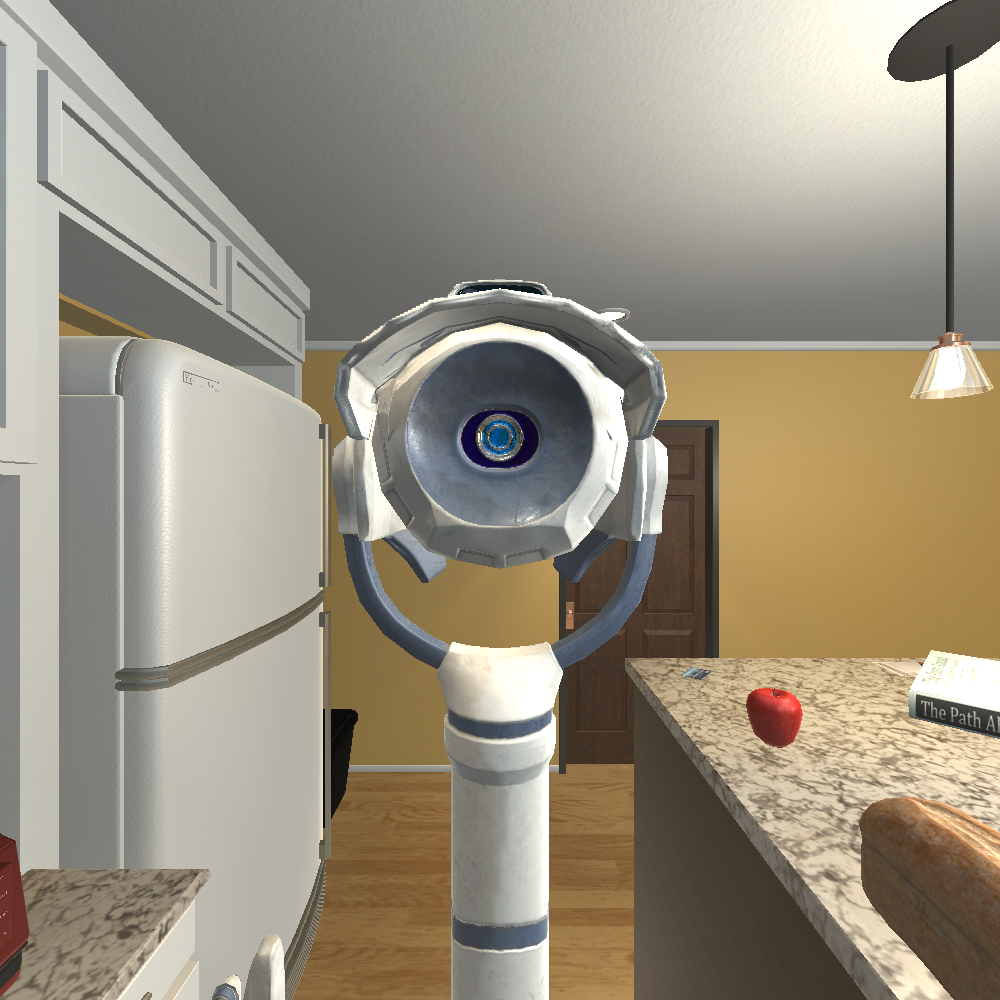

In [ ]:
from PIL import Image

def frame(agent_id=0):
    return (Image.fromarray(env.controller.last_event.events[agent_id].frame))

frame()

## Where is all the information about the environment stored?
Check `print(convert_dict_to_string(env.input_dict)`

In [ ]:
#print(convert_dict_to_string(env.input_dict))

In [ ]:
#print(convert_dict_to_string(env.get_action_llm_input()))

## Get the inital plan

In [ ]:
response = get_gpt_response(action_or_planner="planner")
outdict = get_action(response)
print(outdict)

Got JSON TYPE OUTPUT

{
  "reason": "The mug has been located, but the butter knife and bowl still need to be found. The mug can be moved to the designated countertop area, and the robots need to continue searching for the other items.",
  "plan": [
    "transport Mug_1 to the designated countertop area",
    "locate the butter knife",
    "transport the butter knife to the designated countertop area",
    "locate the bowl",
    "transport the bowl to the designated countertop area"
  ]
}

{'reason': 'The mug has been located, but the butter knife and bowl still need to be found. The mug can be moved to the designated countertop area, and the robots need to continue searching for the other items.', 'plan': ['transport Mug_1 to the designated countertop area', 'locate the butter knife', 'transport the butter knife to the designated countertop area', 'locate the bowl', 'transport the bowl to the designated countertop area']}


## Update the plan in the env.input_dict

In [ ]:
def update_plan(open_subtasks, completed_subtasks):
    env.open_subtasks = open_subtasks
    env.closed_subtasks = completed_subtasks
    env.input_dict["Robots' open subtasks"] = env.open_subtasks
    env.input_dict["Robots' completed subtasks"] = env.closed_subtasks


## Actor module

In [ ]:
env.get_action_llm_input()

{'Task': 'Put the butter knife, bowl, and mug in the countertop',
 "Alice's observation": "['Stove_1', 'Drawer_1', 'Cabinet_1', 'StoveBurner_1', 'Cabinet_2', 'Cabinet_3', 'StoveKnob_1', 'Sink_1', 'Cabinet_4', 'Cabinet_5', 'Mug_1', 'StoveBurner_2', 'StoveKnob_2', 'Cabinet_6', 'UpperCabinets_1', 'StoveBurner_3', 'StoveKnob_3', 'Window_1', 'StandardCounterHeightWidth_1', 'Floor_1', 'Wall_1', 'StandardIslandHeight_1', 'Stove_2', 'Window_2', 'StoveKnob_4', 'Cabinet_7', 'Ceiling_1', 'StoveBurner_4', 'CeilingLight_1', 'CeilingLight_2', 'Faucet_1', 'CeilingLight_3', 'Dishwasher_1', 'LightFixture_1', 'LightFixture2_1', 'Pot_1', 'SaltShaker_1', 'Fridge_1', 'SoapBottle_1', 'HousePlant_1', 'Pan_1', 'Tomato_1', 'PepperShaker_1', 'Apple_1', 'Toaster_1', 'Lettuce_1', 'Spatula_1', 'Microwave_1', 'Potato_1', 'Bread_1', 'CoffeeMachine_1', 'PaperTowelRoll_1', 'Stool_1', 'CounterTop_1', 'CounterTop_2', 'CounterTop_3']",
 "Alice's state": 'I am at co-ordinates: (1.5, -1.5) facing west and I am holding noth

In [ ]:
# env.open_subtasks = outdict["plan"]
# env.closed_subtasks = None
# env.input_dict["Robots' open subtasks"] = env.open_subtasks
# env.input_dict["Robots' completed subtasks"] = env.closed_subtasks
update_plan(outdict["plan"], None)
env.get_action_llm_input()

{'Task': 'Put the butter knife, bowl, and mug in the countertop',
 "Alice's observation": "['Stove_1', 'Drawer_1', 'Cabinet_1', 'StoveBurner_1', 'Cabinet_2', 'Cabinet_3', 'StoveKnob_1', 'Sink_1', 'Cabinet_4', 'Cabinet_5', 'Mug_1', 'StoveBurner_2', 'StoveKnob_2', 'Cabinet_6', 'UpperCabinets_1', 'StoveBurner_3', 'StoveKnob_3', 'Window_1', 'StandardCounterHeightWidth_1', 'Floor_1', 'Wall_1', 'StandardIslandHeight_1', 'Stove_2', 'Window_2', 'StoveKnob_4', 'Cabinet_7', 'Ceiling_1', 'StoveBurner_4', 'CeilingLight_1', 'CeilingLight_2', 'Faucet_1', 'CeilingLight_3', 'Dishwasher_1', 'LightFixture_1', 'LightFixture2_1', 'Pot_1', 'SaltShaker_1', 'Fridge_1', 'SoapBottle_1', 'HousePlant_1', 'Pan_1', 'Tomato_1', 'PepperShaker_1', 'Apple_1', 'Toaster_1', 'Lettuce_1', 'Spatula_1', 'Microwave_1', 'Potato_1', 'Bread_1', 'CoffeeMachine_1', 'PaperTowelRoll_1', 'Stool_1', 'CounterTop_1', 'CounterTop_2', 'CounterTop_3']",
 "Alice's state": 'I am at co-ordinates: (1.5, -1.5) facing west and I am holding noth

In [ ]:
def process_action_llm_output(outdict):
    action = []
    action.append(outdict[f"{agent_name[0]}'s action"])
    action.append(outdict[f"{agent_name[1]}'s action"])
    reason = outdict["reason"]
    subtask = outdict["subtask"]
    memory = outdict["memory"]
    failure_reason = outdict["failure reason"]
    return action, reason, subtask, memory, failure_reason

def print_stuff(action, reason, subtask, memory, failure_reason):
    print("Step: " + str(env.step_num))
    print(f'Action: {action}')
    action = action_checker(action)
    print(f'Closest Action: {action}')
    print(f'Reason: {reason}')
    print(f'Subtask: {subtask}')
    print(f'Memory: {memory}')
    print(f'Failure Reason: {failure_reason}')
    return action

## Get the action

In [ ]:
response = get_gpt_response(action_or_planner="action")
outdict = get_action(response)
action, reason, subtask, memory, failure_reason = process_action_llm_output(outdict)
action = print_stuff(action, reason, subtask, memory, failure_reason)
# print("Step: " + str(env.step_num))
# print(f'Action: {action}')
# action = action_checker(action)
# print(f'Closest Action: {action}')
# print(f'Reason: {reason}')
# print(f'Subtask: {subtask}')
# print(f'Memory: {memory}')
# print(f'Failure Reason: {failure_reason}')


Got NORMAL TYPE OUTPUT
Based on the information provided and the images, we can derive the following actions for Alice and Bob to complete their tasks efficiently:

Alice can see the Mug_1 which is one of the items that needs to be transported to the designated countertop area. Since Alice is not holding anything, she can pick up the mug.

Bob's current observation does not include the butter knife or bowl, which are part of the open subtasks. Bob needs to locate these items. Since Bob is facing west and is near the countertop and cabinets, Bob can start by looking for the butter knife and bowl in the nearby cabinets. Bob could either navigate or rotate to get a better view of the area.

Here's the plan for the next actions:

{"failure reason": "None", 
"memory": "Alice spotted Mug_1 on the countertop. Bob is near the counter and cabinets and needs to locate the butter knife and bowl.", 
"reason": "Alice can pick up Mug_1 since it is within her view and she is not holding anything. Bob

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## Execute the action in the environment

In [ ]:
df = append_row(df, env.step_num, action, reason, subtask, memory)
if config.use_shared_subtask:
    env.update_subtask(subtask, 0)
if config.use_shared_memory:
    env.update_memory(memory, 0)
d1, successes = env.step(action)
previous_action = action
previous_success = successes
print_relevant_info(env.input_dict)


## Verify the action after execution

In [ ]:
env.get_verifier_llm_input()

In [ ]:
response = get_gpt_response(action_or_planner="verifier")
outdict = get_action(response)
outdict


In [ ]:
env.closed_subtasks = outdict["completed subtasks"]
if len(env.closed_subtasks) == 0:
    env.closed_subtasks = None
env.input_dict["Robots' completed subtasks"] = env.closed_subtasks
env.get_planner_llm_input()

In [ ]:
response = get_gpt_response(action_or_planner="planner")
outdict = get_action(response)
outdict

In [ ]:
frame(0)

In [ ]:
frame(1)

## Now repeat from update_plan() cell again.

Don't run a for loop for executing the planner, actor, verifier cells. Rather run them manually for now until you get a reasonably successful completion of the task for a decent number of episodes